# Convert CVAT Image annotation to coco format

In [ ]:
# !pip install python-xml2dict

In [ ]:
%load_ext autoreload
%autoreload 2

from avcv.all import *
from fastcore.all import *
import xml2dict





def get_unique_name(row):
    columns = ['@xtl', '@ytl', '@xbr','@ybr', '@label', '@task_id']
    return '_'.join([row[c] for c in columns])

def load_track_xml2df(path):
    d_image = xml2dict.parse(open(path))['annotations']
    data_bboxes = []
    for track in d_track['track']:
        track_data = {k:track[k] for k in ['@id', '@label', '@task_id']}
        if isinstance(track['box'], dict):
            bboxes = [track['box']]
        elif isinstance(track['box'], list):
            bboxes = track['box']
        else:
            import ipdb; ipdb.set_trace()
        for bbox in bboxes:
            bbox = bbox.copy()
            bbox.update(track_data)
            if bbox['@outside'] == '0':
                data_bboxes.append(bbox)
    df_track = pd.DataFrame(data_bboxes)
    return df_track

def load_image_xml2df(path):
    d_image = xml2dict.parse(open(path))['annotations']

    data_bbox = []

    for image in d_image['image']:
        image_data = {k:image[k] for k in ['@name', '@height', '@width', '@task_id']}
        if 'box' in image:
            if isinstance(image['box'], dict):
                bboxes = [image['box']]
            elif isinstance(image['box'], list):
                bboxes = image['box']
            else:
                1/0
            for bbox in bboxes:
                bbox.update(image_data)
                data_bbox.append(bbox)
        else:
            data_bbox.append(image_data)
    df_image = pd.DataFrame(data_bbox)    
    return df_image
def merge_track_image_annotations(df_track, df_image):
    df_track['uname'] = df_track.apply(get_unique_name, 1)
    name_count = df_track.groupby('uname').size()
    df_track = df_track.set_index('uname')

    name_count.sort_values()


    df_image['uname'] = df_image.apply(get_unique_name, 1)
    df_image = df_image.set_index('uname')

    name_image = set(df_image.index.unique())
    name_track = set(df_track.index.unique())

    df_image = df_image.sort_index()
    df_track = df_track.sort_index()

    df_image['track_id'] = df_track['@id']

    def f(row):
        assert len(row['@label'].unique()) == 1, 'Invalid trackid {}, has more than one label per track???'.format(row.iloc[0]['track_id'])
    df_image.groupby('track_id').apply(f)
    return df_image

df_image = load_image_xml2df('/tmp/anns.xml')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# df_merge['is_action_frame'] = df_merge['@name'].apply(lambda x: x.startswith('Action_'))
# print(df_merge['is_action_frame'].mean())
# df_merge[df_merge['is_action_frame']]
def get_user(row):
    if row['@name'].startswith('Action_'):
        return row['@name'].split('/')[1].split('_')[0]
    else:
        return np.nan
df_image['user'] = df_image.apply(get_user, 1)
val_users = ['hungng', 'chungtd12', 'thomp4', 'thuyhv5']
df_image['is_val'] = df_image.user.apply(lambda x: x in val_users)

In [ ]:
cat_name2id = {v:k+1 for k, v in enumerate(df_image['@label'].dropna().unique())}
cat_name2id

{'phone': 1, 'cigarette': 2, 'food/drink': 3}

In [ ]:
def to_coco_format(df):
    image_name2id = {v:k for k, v in enumerate(df['@name'].dropna().unique())}
    out_dict = dict(images=[], annotations=[], categories=[])
    for _, row in df.iterrows():
        x, y, x2, y2 = [float(row[k]) for k in ['@xtl', '@ytl', '@xbr', '@ybr']]
        if np.isnan(x):
            continue
        w,h = x2-x, y2-y
        ann = dict(id=len(out_dict['annotations']),
                  bbox=[x,y,w,h],
                   area=h*w,
                   category_id=cat_name2id[row['@label']],
                   image_id=image_name2id[row['@name']],
                  )
        out_dict['annotations'].append(ann)
        
    for k, v in image_name2id.items():
        out_dict['images'].append(dict(id=v, file_name=k))
    for k, v in cat_name2id.items():
        out_dict['categories'].append(dict(id=v, name=k))
    
    print('Num images', len(out_dict['images']))
    return out_dict
val_dict = to_coco_format(df_image[df_image.is_val])
train_dict = to_coco_format(df_image[~df_image.is_val])

Num images 5091
Num images 31939


In [ ]:
out_ann_dir = '/data/DMS_Behavior_Detection/annotations/'
out_img_dir ='/data/DMS_Behavior_Detection/images'


In [ ]:
def convert_images_filename(images, old_img_dir, new_img_dir):
    for image in images:
        old_path = osp.abspath(osp.join(old_img_dir, image['file_name']))
        
        imh, imw = Image.open(old_path).size
        image.update(dict(height=imh, width=imw))
        
        image['file_name'] = osp.relpath(old_path, new_img_dir)
    return images
train_dict['images'] = convert_images_filename(train_dict['images'],
                                               '/data/cvat-raw-images/', out_img_dir)
val_dict['images'] = convert_images_filename(val_dict['images'],
                                               '/data/cvat-raw-images/', out_img_dir)

# DUMP

In [ ]:
# missing_count = 0
# count = 0
# with open('/tmp/expect_img_list.txt', 'w') as f:
#     for img in cc.img_ids:
#         img_info = cc.gt.imgs[img]
#         fn = osp.join(cc.img_dir, img_info['file_name'])
#         f.write(fn+'\n')
#         if not osp.exists(fn) :#and not '.jpg' in fn:
#             missing_count += 1
            
#         else:
#             count += 1

In [ ]:
mmcv.mkdir_or_exist(out_ann_dir)
mmcv.dump(train_dict, osp.join(out_ann_dir, 'cvat_train_27_10_2022.json'))
mmcv.dump(val_dict, osp.join(out_ann_dir, 'cvat_val_27_10_2022.json'))

In [ ]:
# cc = CocoDataset(val_dict, '/data/cvat-raw-images/')

In [ ]:
# vis_imgs = []
# for i in range(20):
#     vis_imgs.append(cc.visualize(show=0))
#     if len(vis_imgs) == 4:
        
#         plot_images(vis_imgs)
#         # plt.show()
#         vis_imgs = []

2022-09-27 06:33:00.708 | INFO     | avcv.coco:visualize:190 - Random visualize img_id=1129


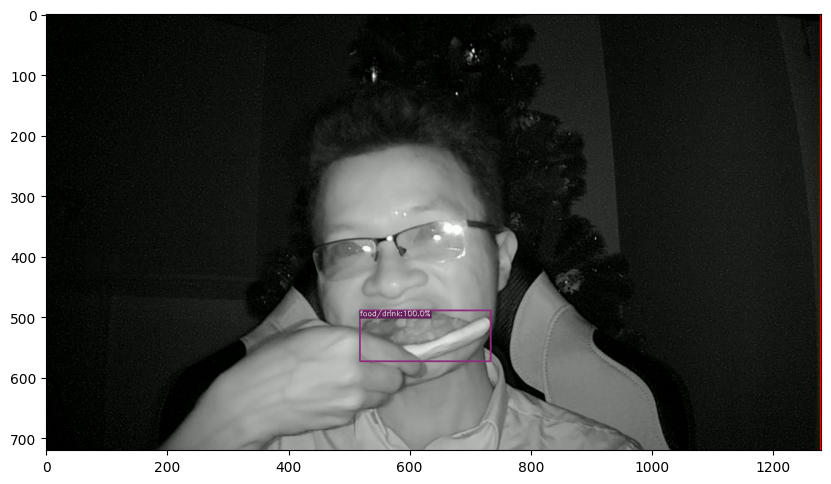

In [ ]:
cc = CocoDataset(val_dict, out_img_dir)
cc.visualize(show=1);